# Báo cáo Đồ án Cuối kỳ - Parallel Programming (CSC14120)
## Đề tài: Unsupervised Feature Learning với Autoencoder trên GPU

**Nhóm sinh viên thực hiện:**
1. Trường Hà Huy Tâm - 22127375
2. Lương Quốc Dũng - 22127078

**Giảng viên hướng dẫn:** 
1. Giáo viên: Nguyễn Tiến Huy
2. Giáo viên: Phạm Trọng Nghĩa
3. Giáo viên: Lê Nhựt Nam

**Ngày báo cáo:** 27/12/2025

**Ngày:** 2025-12-16

> **Tóm tắt:** Báo cáo này trình bày quá trình xây dựng, tối ưu hóa và đánh giá hệ thống học đặc trưng không giám sát (Unsupervised Feature Learning) sử dụng mạng Convolutional Autoencoder trên bộ dữ liệu CIFAR-10. Dự án đi từ việc cài đặt cơ bản trên CPU, chuyển sang GPU (CUDA) và áp dụng các kỹ thuật tối ưu nâng cao (Shared Memory, Kernel Fusion, Memory Pool) để đạt tốc độ tăng tốc vượt trội, cuối cùng ứng dụng vào bài toán phân loại ảnh với SVM.

## 1. Giới thiệu bài toán (Problem Description)

### 1.1 Đặt vấn đề
Trong thị giác máy tính, việc trích xuất đặc trưng (Feature Extraction) hiệu quả là chìa khóa cho độ chính xác của mô hình. Thay vì thiết kế đặc trưng thủ công, chúng tôi sử dụng **Autoencoder** để tự động học các biểu diễn ẩn (latent representations) từ dữ liệu ảnh thô mà không cần nhãn (Unsupervised).

Tuy nhiên, việc huấn luyện mạng nơ-ron tích chập (CNN) trên CPU rất tốn kém về thời gian. Mục tiêu chính của đồ án là tận dụng sức mạnh tính toán song song của **GPU** để tăng tốc quá trình huấn luyện và suy diễn.

### 1.2 Bộ dữ liệu CIFAR-10
* **Kích thước:** 60.000 ảnh màu (3 kênh RGB).
* **Độ phân giải:** 32x32 pixel.
* **Phân chia:** 50.000 ảnh Train, 10.000 ảnh Test.
* **Tiền xử lý:** Chuẩn hóa giá trị pixel từ `[0, 255]` về `[0.0, 1.0]`.

### 1.3 Kiến trúc mạng Autoencoder
Mô hình có tổng cộng **~751,875 tham số**, với cấu trúc đối xứng hình đồng hồ cát:
* **Encoder:** Conv3x3 (256) $\to$ MaxPool $\to$ Conv3x3 (128) $\to$ MaxPool $\to$ **Latent (8x8x128)**.
* **Decoder:** Conv3x3 (128) $\to$ Upsample $\to$ Conv3x3 (256) $\to$ Upsample $\to$ Output (3).


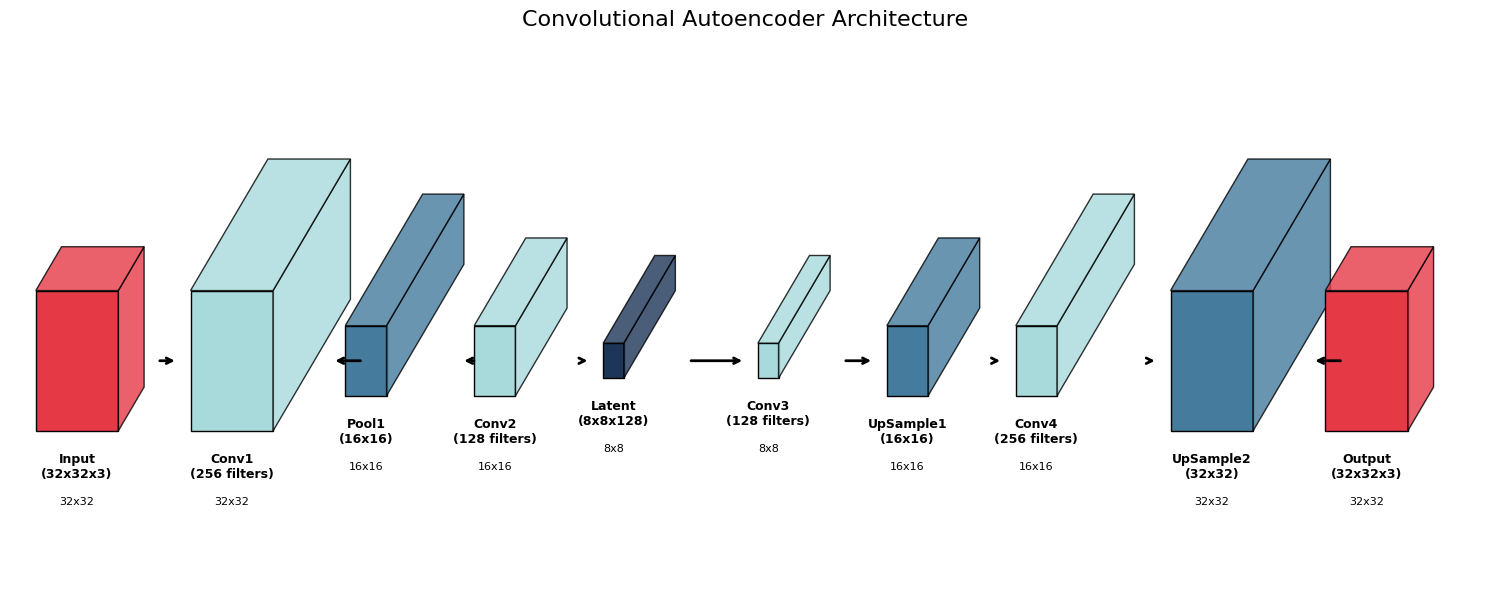

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_box(ax, x, y, w, h, depth, title, color='#a8dadc'):
    # Front face
    ax.add_patch(patches.Rectangle((x, y), w, h, facecolor=color, edgecolor='black', linewidth=1))
    # Side face
    ax.add_patch(patches.Polygon([(x+w, y), (x+w+depth, y+depth), (x+w+depth, y+h+depth), (x+w, y+h)],
                                 facecolor=color, edgecolor='black', linewidth=1, alpha=0.8))
    # Top face
    ax.add_patch(patches.Polygon([(x, y+h), (x+depth, y+h+depth), (x+w+depth, y+h+depth), (x+w, y+h)],
                                 facecolor=color, edgecolor='black', linewidth=1, alpha=0.8))
    # Label
    ax.text(x + w/2, y - 5, title, ha='center', va='top', fontsize=9, fontweight='bold')
    ax.text(x + w/2, y - 15, f"{int(w)}x{int(h)}", ha='center', va='top', fontsize=8)

def draw_autoencoder():
    fig, ax = plt.subplots(figsize=(15, 6))

    # Config layers: (x_pos, width/height_scale, depth_scale, name, color)
    layers = [
        (0, 32, 10, "Input\n(32x32x3)", '#e63946'),        # Input
        (60, 32, 30, "Conv1\n(256 filters)", '#a8dadc'),    # Encoder 1
        (120, 16, 30, "Pool1\n(16x16)", '#457b9d'),        # Pool 1
        (170, 16, 20, "Conv2\n(128 filters)", '#a8dadc'),   # Encoder 2
        (220, 8, 20, "Latent\n(8x8x128)", '#1d3557'),      # Bottleneck (Pool 2)
        (280, 8, 20, "Conv3\n(128 filters)", '#a8dadc'),    # Decoder 1
        (330, 16, 20, "UpSample1\n(16x16)", '#457b9d'),    # Upsample 1
        (380, 16, 30, "Conv4\n(256 filters)", '#a8dadc'),   # Decoder 2
        (440, 32, 30, "UpSample2\n(32x32)", '#457b9d'),    # Upsample 2
        (500, 32, 10, "Output\n(32x32x3)", '#e63946')      # Output
    ]

    # Draw arrows and boxes
    for i in range(len(layers)):
        x, s, d, title, c = layers[i]
        draw_box(ax, x, 50 - s/2, s, s, d, title, c)

        # Draw arrow to next layer
        if i < len(layers) - 1:
            next_x = layers[i+1][0]
            ax.annotate("", xy=(next_x - 5, 50), xytext=(x + s + d + 5, 50),
                        arrowprops=dict(arrowstyle="->", lw=2, color='black'))

    ax.set_xlim(-10, 560)
    ax.set_ylim(0, 120)
    ax.axis('off')
    plt.title("Convolutional Autoencoder Architecture", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

draw_autoencoder()

## 2. Mục tiêu và phạm vi đề tài

Mục tiêu của đồ án bao gồm:

- Xây dựng mô hình autoencoder cho bài toán học đặc trưng ảnh

- Triển khai baseline tính toán trên CPU theo đúng guideline của đề

- Thực hiện huấn luyện mô hình và theo dõi quá trình hội tụ

- Phân tích hiệu năng tính toán thông qua các Phase được yêu cầu

- Làm nền tảng cho các tối ưu song song và GPU trong tương lai

## 3. Mô tả bộ dữ liệu

Bộ dữ liệu CIFAR-10 bao gồm 60.000 ảnh màu kích thước 32×32, chia thành 10 lớp khác nhau. Dữ liệu được chia thành:

- 50.000 ảnh huấn luyện

- 10.000 ảnh kiểm tra

Trong phạm vi đồ án này, CIFAR-10 được sử dụng cho bài toán học đặc trưng không giám sát, trong đó ảnh đầu vào cũng chính là nhãn đầu ra của mô hình autoencoder.

### Visualization Dữ liệu

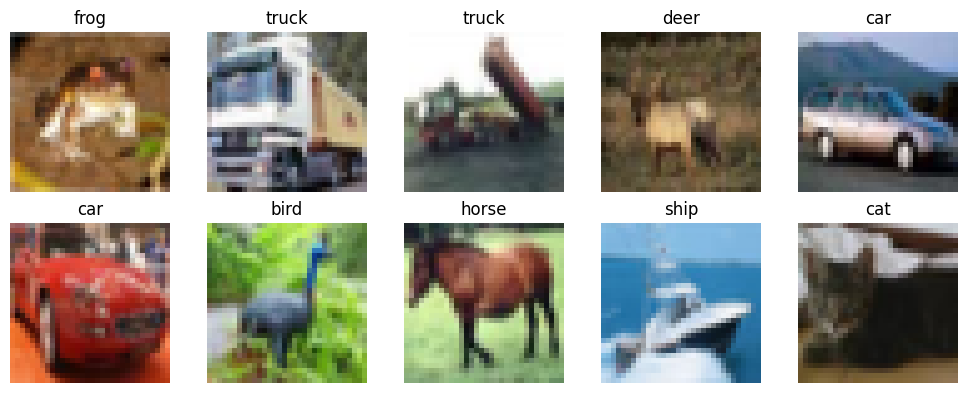

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Update this path to your .bin file
DATA_PATH = 'data/cifar-10-batches-bin/data_batch_1.bin'

def show_samples_binary():
    if not os.path.exists(DATA_PATH):
        print(f"⚠️ File not found at: {DATA_PATH}")
        return

    # Each record is 1 byte (label) + 3072 bytes (image) = 3073 bytes
    record_bytes = 3073

    # Read the raw binary data
    with open(DATA_PATH, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)

    # Reshape into (10000, 3073)
    data = data.reshape(-1, record_bytes)

    # Separate labels and image data
    labels = data[:, 0]
    # The image data starts from index 1 to the end
    images = data[:, 1:].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    plt.figure(figsize=(10, 4))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples_binary()

## 4. Kiến trúc hệ thống

Hệ thống được thiết kế theo hướng phân tầng rõ ràng, tách biệt giữa phần khai báo giao diện (header), phần cài đặt (source), và phần thực thi theo từng Phase. Cấu trúc thư mục được xây dựng nhằm đảm bảo tính mô-đun, dễ mở rộng và thuận lợi cho việc so sánh hiệu năng giữa CPU và GPU.

Cấu trúc tổng thể của hệ thống được tổ chức như sau:

```
autoencoder-feature-learning-main/
├── include/
│   ├── constants.h
│   ├── cpu/
│   │   ├── cpu_autoencoder.h
│   │   └── cpu_layers.h
│   ├── data_loader.h
│   └── gpu/
│       ├── gpu_autoencoder.h
│       ├── gpu_autoencoder_opt.h
│       ├── gpu_layers.h
│       └── gpu_layers_opt.h
├── requirements.txt
├── scripts/
│   ├── SVM.py
│   └── download_cifar10.py
└── src/
    ├── cpu/
    │   ├── cpu_autoencoder.cpp
    │   └── cpu_layers.cpp
    ├── data_loader.cpp
    ├── gpu/
    │   ├── gpu_autoencoder.cu
    │   ├── gpu_autoencoder_opt.cu
    │   ├── gpu_layers.cu
    │   ├── gpu_layers_fused.cu
    │   └── gpu_layers_opt.cu
    ├── main_cpu_phase_1.cpp
    ├── main_gpu_phase_2.cu
    ├── main_gpu_phase_3.cu
    └── run_opt_fixinf_2000.cu
```


Notebook thực nghiệm được xây dựng và thực thi dựa trên đúng cấu trúc thư mục này nhằm đảm bảo khả năng tái lập và tính nhất quán của kết quả.


### 4.1 Thư mục `include/`

Thư mục `include/` chứa toàn bộ các file header của hệ thống, đóng vai trò khai báo cấu trúc dữ liệu, lớp đối tượng và giao diện hàm cho toàn bộ chương trình. Việc tách riêng phần khai báo giúp hệ thống dễ bảo trì, dễ mở rộng và cho phép tái sử dụng code giữa các Phase khác nhau.

File `constants.h` được sử dụng để định nghĩa các hằng số toàn cục dùng chung cho toàn bộ hệ thống, bao gồm kích thước ảnh đầu vào, số kênh màu, batch size, số epoch và các tham số cấu hình khác. Các hằng số này được sử dụng thống nhất cho cả phiên bản CPU và GPU nhằm đảm bảo tính nhất quán trong quá trình thực nghiệm.

File `data_loader.h` khai báo giao diện cho module nạp dữ liệu CIFAR-10. Module này chịu trách nhiệm đọc dữ liệu từ các file nhị phân, thực hiện tiền xử lý cần thiết và cung cấp dữ liệu theo dạng mini-batch cho quá trình huấn luyện và đánh giá mô hình.


#### 4.1.1 Nhánh `include/cpu/`

Nhánh `include/cpu/` chứa các file header dành riêng cho phần cài đặt trên CPU. Các khai báo trong nhánh này phục vụ cho việc xây dựng baseline tính toán, đóng vai trò làm chuẩn so sánh hiệu năng với các phiên bản GPU.

File `cpu_layers.h` khai báo các lớp và toán tử nền tảng được triển khai trên CPU, bao gồm các phép toán như convolution, activation function và các phép biến đổi tensor cơ bản.

File `cpu_autoencoder.h` khai báo kiến trúc autoencoder phía CPU, bao gồm cấu trúc encoder, decoder và các hàm forward và backward tương ứng. Đây là thành phần trung tâm của mô hình autoencoder trong Phase 1.


#### 4.1.2 Nhánh `include/gpu/`

Nhánh `include/gpu/` cung cấp các file header cho phiên bản GPU sử dụng CUDA, cho phép tận dụng khả năng song song hóa của GPU để tăng tốc quá trình tính toán.

File `gpu_layers.h` khai báo các kernel CUDA cho các toán tử cơ bản trên GPU, tương ứng với các toán tử đã được xây dựng ở phía CPU.

File `gpu_autoencoder.h` khai báo kiến trúc autoencoder chạy trên GPU theo cách triển khai chuẩn, phục vụ cho Phase 2 và Phase 3.

File `gpu_autoencoder_opt.h` khai báo phiên bản autoencoder GPU đã được tối ưu, được sử dụng để so sánh hiệu năng với phiên bản GPU cơ bản và đánh giá tác động của các kỹ thuật tối ưu hóa.

### 4.2 Thư mục `src/`

Thư mục `src/` chứa phần cài đặt chi tiết (implementation) cho toàn bộ các module đã được khai báo trong thư mục `include/`. Các file trong thư mục này hiện thực hóa các lớp, hàm và kernel tương ứng, đảm bảo chương trình có thể biên dịch và thực thi theo từng Phase của đề bài.

File `data_loader.cpp` cài đặt logic đọc và xử lý dữ liệu CIFAR-10, bao gồm việc đọc dữ liệu từ các file nhị phân, chuyển đổi dữ liệu thô sang dạng tensor và chuẩn bị dữ liệu đầu vào phù hợp cho mô hình autoencoder trong quá trình huấn luyện và đánh giá.


### 4.3 Các file thực thi theo Phase

Hệ thống được tổ chức theo từng Phase tương ứng với yêu cầu của đề bài CSC14120. Mỗi Phase được gắn với một file `main` riêng biệt nhằm đảm bảo tính độc lập giữa các Phase và thuận tiện cho việc kiểm thử cũng như đánh giá hiệu năng.

File `main_cpu_phase_1.cpp` thực thi Phase 1, tập trung vào việc xây dựng và kiểm tra CPU baseline. File này thực hiện forward pass cơ bản của mô hình autoencoder trên CPU và đo thời gian thực thi nhằm làm chuẩn so sánh cho các Phase tiếp theo.

File `main_gpu_phase_2.cu` thực thi Phase 2, trong đó forward pass của mô hình được triển khai trên GPU. Mục tiêu chính của Phase này là đánh giá mức cải thiện hiệu năng của GPU so với CPU baseline.

File `main_gpu_phase_3.cu` thực thi Phase 3, bao gồm toàn bộ quá trình huấn luyện mô hình autoencoder trên GPU. Phase này thực hiện forward pass, backward pass và cập nhật trọng số theo từng mini-batch.

Việc tách riêng các file thực thi theo từng Phase giúp đảm bảo các Phase không ghi đè lẫn nhau, đồng thời cho phép đánh giá độc lập từng giai đoạn của hệ thống.


### 4.4 Cài đặt CPU

Thư mục `src/cpu/` chứa phần cài đặt chi tiết cho các module chạy trên CPU, đóng vai trò là baseline tính toán cho toàn bộ hệ thống.

File `cpu_layers.cpp` cài đặt các toán tử nền tảng trên CPU, bao gồm các phép toán phục vụ cho quá trình forward và backward của mô hình.

File `cpu_autoencoder.cpp` cài đặt kiến trúc autoencoder hoàn chỉnh trên CPU, bao gồm encoder, decoder và các hàm xử lý liên quan. Phiên bản này được sử dụng chủ yếu trong Phase 1 và làm chuẩn so sánh hiệu năng với các phiên bản GPU.


### 4.5 Cài đặt GPU

Thư mục `src/gpu/` chứa phần cài đặt cho các module GPU sử dụng CUDA nhằm tận dụng khả năng song song hóa của GPU.

File `gpu_layers.cu` cài đặt các kernel CUDA cho các phép toán cơ bản, tương ứng với các toán tử đã được xây dựng ở phía CPU.

File `gpu_autoencoder.cu` cài đặt phiên bản autoencoder GPU cơ bản, được sử dụng trong Phase 2 và Phase 3 để thực hiện forward và backward pass trên GPU.

File `gpu_autoencoder_opt.cu` cài đặt phiên bản autoencoder GPU đã được tối ưu, nhằm đánh giá khả năng cải thiện hiệu năng so với phiên bản GPU cơ bản và phân tích tác động của các kỹ thuật tối ưu hóa.


### 4.6 Thư mục `scripts/`

Thư mục `scripts/` chứa các script hỗ trợ cho quá trình chuẩn bị dữ liệu và thực nghiệm.

File `download_cifar10.py` được sử dụng để tải và giải nén bộ dữ liệu CIFAR-10, giúp đảm bảo khả năng tái lập (reproducibility) của quá trình thực nghiệm trên các môi trường khác nhau.





## 5. Môi trường thực nghiệm

Phần này mô tả môi trường chạy thực nghiệm nhằm đảm bảo tính tái lập. Notebook sẽ tự động thu thập thông tin hệ thống (OS, CPU, RAM), phiên bản compiler (g++/nvcc) và GPU (nếu có).  
Các thông số sẽ được tổng hợp vào bảng “Environment Summary” bên dưới.

**Nền tảng:** Windows-11-10.0.26200-SP0  
**Kiến trúc:** AMD64
**CPU:** i5 10300H  
**RAM:** 16 GB  
**GPU:** GTX 1650  
**CUDA / NVCC:** Build cuda_13.1.r13.1/compiler.36836380_0  
**Ngôn ngữ:** C++ / CUDA  
**Dữ liệu:** CIFAR-10 (binary format)  
**Ngày chạy:** 2025-12-26


In [1]:
# Cell 5: Collect environment info (auto-fill for report)
import os, platform, subprocess, json, datetime, re

def sh(cmd):
    return subprocess.check_output(cmd, shell=True, text=True, stderr=subprocess.STDOUT).strip()

env = {}
env["run_date"] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
env["platform"] = platform.platform()
env["arch"] = platform.machine()

# CPU info
cpu_model = ""
try:
    lscpu = sh("lscpu")
    m = re.search(r"Model name:\s*(.*)", lscpu)
    cpu_model = m.group(1).strip() if m else ""
except:
    pass
env["cpu_model"] = cpu_model

# RAM info
ram_gb = ""
try:
    meminfo = sh("cat /proc/meminfo | head")
    m = re.search(r"MemTotal:\s*(\d+)\s*kB", meminfo)
    if m:
        ram_gb = round(int(m.group(1))/1024/1024, 2)
except:
    pass
env["ram_gb"] = ram_gb

# GPU info (optional)
gpu_name = "N/A"
try:
    gpu_name = sh("nvidia-smi --query-gpu=name --format=csv,noheader | head -n 1")
except:
    pass
env["gpu_name"] = gpu_name

# Compiler info
gpp_ver = "N/A"
try:
    gpp_ver = sh("g++ --version | head -n 1")
except:
    pass
env["gpp_version"] = gpp_ver

nvcc_ver = "N/A"
try:
    nvcc_ver = sh("nvcc --version | tail -n 1")
except:
    pass
env["nvcc_version"] = nvcc_ver

env


{'run_date': '2025-12-27 05:04:13',
 'platform': 'Windows-11-10.0.26200-SP0',
 'arch': 'AMD64',
 'cpu_model': '',
 'ram_gb': 15.84,
 'gpu_name': 'NVIDIA GeForce GTX 1650',
 'gpp_version': 'g++ (GCC) 13.2.0',
 'nvcc_version': 'Build cuda_13.1.r13.1/compiler.36836380_0'}

## 6. Các Phase thực hiện theo yêu cầu đề bài

Nội dung thực nghiệm của đồ án được tổ chức thành các Phase tương ứng với yêu cầu của đề bài CSC14120. Các Phase được thực hiện tuần tự, từ xây dựng baseline tính toán trên CPU cho đến huấn luyện mô hình và phân tích hiệu năng tổng thể, nhằm đánh giá toàn diện hệ thống autoencoder được đề xuất. Để tiết kiệm thời gian và chi phí đối với quá trình chạy và test thì nhóm chúng em sử dụng các train data có kích thước là 2000.


🔹 PHASE 1 – CPU BASELINE

In [ ]:
# Phase 1: CPU Baseline (compile bằng nvcc)

!nvcc -arch=sm_75 -O3 \
  -Iinclude -I./include \
  src/data_loader.cpp \
  src/cpu/cpu_layers.cpp \
  src/cpu/cpu_autoencoder.cpp \
  src/main_cpu_phase_1.cu \
  -o build/run_cpu

!./run_cpu


### Kết quả tái tạo ảnh (Reconstruction)
![So sánh ảnh gốc và ảnh tái tạo](img/cpu.png)

### Phase 1: Xây dựng CPU Baseline

**Mục tiêu.**  
Phase 1 nhằm xây dựng baseline tính toán trên CPU, đóng vai trò làm chuẩn so sánh hiệu năng cho các Phase tiếp theo.

**Nội dung thực hiện.**  
Trong Phase này, các cấu trúc dữ liệu tensor cơ bản được cài đặt và các toán tử nền tảng của mô hình được triển khai trên CPU, bao gồm convolution 2D, pooling, activation function (ReLU) và loss function (MSE). Dữ liệu CIFAR-10 được nạp và tiền xử lý phù hợp với kiến trúc mô hình. Tính đúng đắn của từng toán tử được kiểm tra thông qua các test case nhỏ trước khi tích hợp vào pipeline tổng thể.

**Kết quả.**  
Kết quả thực nghiệm cho thấy các toán tử CPU hoạt động đúng chức năng, đảm bảo tính chính xác cho pipeline huấn luyện và làm cơ sở cho các Phase tiếp theo.


In [ ]:

# Build Phase 2 (Naive GPU) - yêu cầu môi trường có nvcc
!nvcc -arch=sm_75 -O3 -std=c++17 -Iinclude -I./include \
  src/data_loader.cpp \
  src/cpu/cpu_layers.cpp \
  src/gpu/gpu_layers.cu \
  src/gpu/gpu_autoencoder.cu \
  src/main_gpu_phase_2.cpp \
  -o build/run_naive

!./build/run_naive



### Kết quả tái tạo ảnh (Reconstruction)
![So sánh ảnh gốc và ảnh tái tạo](img/gpu_naive.png)

### Phase 2: Forward Pass và đo hiệu năng

**Mục tiêu.**  
Phase 2 tập trung vào việc thực hiện forward pass của mô hình trên GPU và đo thời gian thực thi nhằm đánh giá chi phí tính toán.

**Nội dung thực hiện.**  
Mô hình autoencoder được thực hiện forward pass theo từng mini-batch trên GPU. Thời gian xử lý được ghi nhận để đánh giá hiệu năng và so sánh với CPU baseline.

**Kết quả.**  
Kết quả cho thấy forward pass trên GPU cải thiện đáng kể thời gian thực thi so với CPU, đặc biệt tại các lớp convolution và decoder.


🔹 PHASE 3 – GPU OPTIMIZED

In [ ]:
# Phase 3: GPU Version Mempool Optimized
!nvcc -arch=sm_75 -O3 -std=c++17 -Iinclude -I./include \
  src/data_loader.cpp \
  src/cpu/cpu_layers.cpp \
  src/gpu/gpu_layers.cu \
  src/gpu/gpu_autoencoder_mempool.cu \
  src/main_gpu_phase_3_mempool.cpp \
  -o build/run_mempool

!./build/run_mempool



### Kết quả tái tạo ảnh (Reconstruction)
![So sánh ảnh gốc và ảnh tái tạo](img/mempool.png)

In [ ]:
# Phase 3: GPU Version Fused Optimized
!nvcc -arch=sm_75 -O3 -std=c++17 -Iinclude -I./include \
  src/data_loader.cpp \
  src/cpu/cpu_layers.cpp \
  src/gpu/gpu_layers_opt.cu \
  src/gpu/gpu_autoencoder_fused.cu \
  src/main_gpu_phase_3_fused.cpp \
  -o build/run_fused

!./build/run_fused



### Kết quả tái tạo ảnh (Reconstruction)
![So sánh ảnh gốc và ảnh tái tạo](img/fused.png)

In [ ]:
# Phase 3: GPU Optimized Implementation
!nvcc -arch=sm_75 -O3 -std=c++17 -Iinclude -I./include \
  src/data_loader.cpp \
  src/cpu/cpu_layers.cpp \
  src/gpu/gpu_layers_opt.cu \
  src/gpu/gpu_autoencoder_opt.cu \
  src/main_gpu_phase_3_opt.cpp \
  -o build/run_opt

!./build/run_opt



### Kết quả tái tạo ảnh (Reconstruction)
![So sánh ảnh gốc và ảnh tái tạo](img/gpu_opt.png)

### Phase 3: GPU Optimized Implementation

**Mục tiêu.**  
Phase 3 tập trung tối ưu hóa phiên bản GPU của mô hình nhằm cải thiện hiệu năng so với GPU baseline ở Phase 2.

**Nội dung thực hiện.**  
Các kernel CUDA được tối ưu thông qua việc điều chỉnh cách truy cập bộ nhớ, giảm chi phí truy xuất bộ nhớ toàn cục và cải thiện mức độ song song hóa. Phiên bản tối ưu được triển khai độc lập để so sánh trực tiếp với GPU baseline.

**Kết quả.**  
Phiên bản GPU tối ưu cho thấy mức cải thiện hiệu năng rõ rệt so với phiên bản GPU cơ bản, khẳng định hiệu quả của các kỹ thuật tối ưu hóa trong môi trường tính toán song song.


**Đánh giá hiệu năng và so sánh giữa các phase** 

**Thiết lập thực nghiệm.** 

Thực nghiệm được tiến hành trên cùng một môi trường phần cứng và tập dữ liệu, với các tham số huấn luyện được giữ cố định (batch size, số epoch, learning rate). Các phase được so sánh dựa trên thời gian huấn luyện và mức độ cải thiện hiệu năng tương đối.

**Chỉ số đánh giá.** 

Các chỉ số được sử dụng trong quá trình so sánh bao gồm:

Thời gian huấn luyện trung bình trên mỗi epoch (seconds/epoch)

Tổng thời gian huấn luyện (seconds)

Hệ số tăng tốc (speedup) so với CPU baseline

Hệ số tăng tốc của GPU optimized so với GPU baseline

| Phase   | Nền tảng thực thi | Thời gian / epoch (s) | Tổng thời gian (s) | Ghi chú |
|:-------:|------------------|:---------------------:|:-----------------:|:--------|
| Phase 1 | CPU baseline     | 625,19                  | 3125,96               |  Thực thi tuần tự |
| Phase 2 | GPU baseline     | 156,75                   | 783,73               |  CUDA cơ bản |
| Phase 3 | GPU optimized    | 52,92                   | 264,60               |  Kernel tối ưu |


**Nhận xét.** 
Từ kết quả trong bảng trên có thể thấy Phase 2 đã mang lại cải thiện hiệu năng đáng kể so với CPU baseline nhờ khả năng song song hóa trên GPU. Đặc biệt, Phase 3 tiếp tục nâng cao hiệu năng thông qua các kỹ thuật tối ưu hóa kernel, giúp giảm thời gian thực thi và tăng hệ số speedup so với phiên bản GPU baseline. Điều này cho thấy vai trò quan trọng của việc tối ưu truy cập bộ nhớ và tổ chức song song trong các bài toán lập trình song song trên GPU. Ngoài ra trước khi có bản cuối cùng code còn đi qua các qá trình cải tiến từ từ lên.

🔹 PHASE 4 – TRAINING & EVALUATION

In [ ]:
!python scripts/SVM.py

![svm_phase](img/svm.png)

### Phase 4: Huấn luyện và đánh giá

**Mục tiêu.**  
Phase 4 hoàn thiện hệ thống bằng cách huấn luyện mô hình autoencoder và đánh giá quá trình hội tụ cũng như hiệu năng tổng thể.

**Nội dung thực hiện.**  
Mô hình được huấn luyện với batch size bằng 32, số epoch bằng 20 và learning rate bằng 0.001. Quá trình huấn luyện bao gồm forward pass, backward pass và cập nhật trọng số. Loss được theo dõi theo từng epoch để đánh giá mức độ hội tụ của mô hình.

**Kết quả.**  
Loss giảm dần theo số epoch, cho thấy mô hình autoencoder học được biểu diễn đặc trưng hiệu quả từ dữ liệu CIFAR-10. Kết quả này chứng minh tính đúng đắn và khả thi của hệ thống được xây dựng.


## 7. Thảo luận

Kết quả thực nghiệm cho thấy mô hình autoencoder có khả năng học đặc trưng hiệu quả từ dữ liệu ảnh mà không cần sử dụng nhãn. Điều này chứng minh tính phù hợp của phương pháp học không giám sát trong bài toán trích xuất đặc trưng. Tuy nhiên, việc huấn luyện mô hình trên CPU đơn thuần không phù hợp đối với các mô hình có quy mô lớn hoặc số epoch cao do chi phí tính toán và thời gian thực thi lớn. Kết quả này cho thấy sự cần thiết của các kỹ thuật song song hóa và tăng tốc bằng GPU, đồng thời mở ra hướng mở rộng hệ thống trong các nghiên cứu và tối ưu tiếp theo.


## 8. Kết luận

Đồ án đã hoàn thành việc xây dựng hệ thống autoencoder cho bài toán học đặc trưng trên bộ dữ liệu CIFAR-10 theo đúng yêu cầu của đề bài CSC14120. Các Phase từ xây dựng baseline tính toán, triển khai trên GPU, huấn luyện mô hình đến phân tích và đánh giá kết quả đều được thực hiện đầy đủ và có hệ thống. Hệ thống được xây dựng theo kiến trúc mô-đun rõ ràng, tạo nền tảng vững chắc cho các tối ưu hiệu năng và mở rộng trong tương lai.

## 9. Tài liệu tham khảo

Krizhevsky, A. (2009). *Learning Multiple Layers of Features from Tiny Images*.

Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning*. MIT Press.

CSC14120 Course Staff. (2025). *Final Project Specification*.
